In [1]:
from pathlib import Path
import numpy as np
from hilde.parsers import read_aims, read_aims_output
from hilde.phonopy import phono as ph
from hilde.structure.convert import phonopy_to_ASE_atoms
from ase.dft.kpoints import get_cellinfo, special_paths, bandpath
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
atoms = read_aims('geometry.in')
vol = atoms.get_volume()

In [3]:
smatrix = 1*np.array([[-1,  1,  1],
                      [ 1, -1,  1],
                      [ 1,  1, -1]])

In [4]:
help(ph.preprocess)

Help on function preprocess in module hilde.phonopy.phono:

preprocess(atoms, supercell_matrix, disp=0.01, symprec=1e-05, trigonal=False)
    Creates a phonopy object from given input
    Args:
        atoms: atoms object that represents the (primitive) unit cell
        smatrix: supercell matrix
        disp: displacement for the finite displacemt
    
    Returns:
        namedtuple with the phonon object, the supercell
        and the supercells_with_displacements as ase.atoms



In [5]:
phonon, sc, scs = ph.preprocess(atoms, smatrix)
phonon, sc, scs

(<phonopy.api_phonopy.Phonopy at 0x147e5da13208>,
 Atoms(symbols='Si8', pbc=True, cell=[[5.42606752582, -2.5738908917179643e-18, 0.0], [-2.5738908917179643e-18, 5.42606752582, 0.0], [2.5738908917179643e-18, 2.5738908917179643e-18, 5.42606752582]], masses=...),
 [Atoms(symbols='Si8', pbc=True, cell=[[5.42606752582, -2.5738908917179643e-18, 0.0], [-2.5738908917179643e-18, 5.42606752582, 0.0], [2.5738908917179643e-18, 2.5738908917179643e-18, 5.42606752582]], masses=...)])

In [6]:
# Define working directory and create it
workdir = Path('./Si_{}{}{}_{}{}{}_{}{}{}_{:.3f}'.format(*smatrix.flatten(), vol))
workdir.mkdir(exist_ok=True)

In [7]:
# Collect the forces
force_sets = []
workdirs = sorted(workdir.glob('disp-???'))
for wd in workdirs:
    try:
        forces = read_aims_output(str(wd / 'aims.out'))[0].get_forces()
    except FileNotFoundError:
        exit(f'Please calculate the forces in {wd} in order to proceed.')
    force_sets.append(forces)
print(f'.. {len(force_sets)} force(s) have been read from aims output files.')

.. 1 force(s) have been read from aims output files.


In [8]:
phonon.produce_force_constants()

False

In [9]:
ph.get_force_constants(phonon)

**Force constants not yet created, please specify force_sets.


In [10]:
phonon.set_forces(force_sets)
phonon.produce_force_constants()

True

In [11]:
phonon.get_force_constants() is not None

True

In [12]:
fcs = ph.get_force_constants(phonon, force_sets)

In [13]:
phonon.produce_force_constants()

True

In [14]:
dos = ph.get_dos(phonon=phonon)

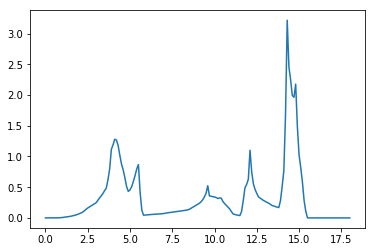

In [15]:
plt.plot(dos[0], dos[1])

In [16]:
cellinfo = get_cellinfo(atoms.cell)

In [17]:
cellinfo.special_points

{'G': array([0, 0, 0]),
 'K': array([0.375, 0.375, 0.75 ]),
 'L': array([0.5, 0.5, 0.5]),
 'U': array([0.625, 0.25 , 0.625]),
 'W': array([0.5 , 0.25, 0.75]),
 'X': array([0.5, 0. , 0.5])}

In [18]:
cellinfo.lattice

'fcc'

In [19]:
paths = special_paths[cellinfo.lattice]
paths

'GXWKGLUWLK,UX'

In [20]:
path = bandpath(paths, atoms.cell)

In [21]:
help(ph.get_bandstructure)

Help on function get_bandstructure in module hilde.phonopy.phono:

get_bandstructure(phonon, path, force_sets=None)
    Compute bandstructure for given path
    
    Args:
        phonon: Phonopy object
        path: path in the Brillouin zone
        force_sets: (optional)
    
    Returns:
        (qpoints, distances, frequencies, eigenvectors)



In [22]:
qp, dd, fr, ev = ph.get_bandstructure(phonon, path)

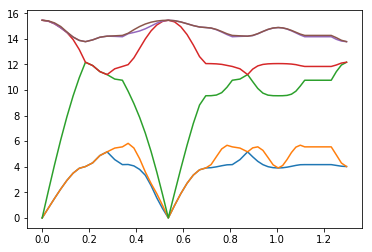

In [23]:
plt.plot(dd[0], fr[0])